In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
device

'cpu'

## Neural Network Model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)

### Differential equation
$$\frac{d^2\phi(r)}{dr^2} + \frac{2m}{\hbar^2}\left(E-\frac{l(l+1)}{2mr^2}\hbar^2-V(r)\right)\phi(r) = 0$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\phi_t(r) = e^{-\beta r^2}N(r,\vec{p})$, with $\phi(r=0) = 0$ and $\phi(r\rightarrow\infty) = 0$ as boundary conditions.  

In [36]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [37]:
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0001)
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0
V = lambda r: -(Z*e**2)/r
Phi_t = lambda r: torch.exp(-beta*r**2) * model.forward(r)

In [38]:
def loss_fn(r):
    r.requires_grad = True
    
    outputs = Phi_t(r)
    Phi_t_r = torch.autograd.grad(outputs, r, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi_t = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*outputs
    
    prom = outputs.size()[0]
    
    delta = r[1]-r[0]
    norm = torch.sum(outputs**2)*delta
    
    global E
    E = (torch.sum(outputs*H_Phi_t)*delta)/norm
    
    return (torch.mean((H_Phi_t - E*outputs)**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [39]:
upper_r = 6
lower_r = 1e-2
steps = 100
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(R_train.to(device))}")
    training(R_train, loss_fn, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: tensor([18261.6543], grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([204.1204], grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([203.4663], grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([202.8147], grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([202.1600], grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([201.5081], grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([200.8564], grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([200.2056], grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([199.5465], grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([198.8852], grad_fn=<DivBackward0>)
Epoch 11
 ---------------------- loss: tensor([198.2242], grad_fn=<DivBackward0>)
Epoch 12
 ---------------------- loss: tensor([197.5576], grad_fn=<DivBackward0>)
Epoch 13
 -------------

Epoch 104
 ---------------------- loss: tensor([65.7871], grad_fn=<DivBackward0>)
Epoch 105
 ---------------------- loss: tensor([65.6721], grad_fn=<DivBackward0>)
Epoch 106
 ---------------------- loss: tensor([65.5894], grad_fn=<DivBackward0>)
Epoch 107
 ---------------------- loss: tensor([65.4887], grad_fn=<DivBackward0>)
Epoch 108
 ---------------------- loss: tensor([64.5562], grad_fn=<DivBackward0>)
Epoch 109
 ---------------------- loss: tensor([64.5561], grad_fn=<DivBackward0>)
Epoch 110
 ---------------------- loss: tensor([64.5561], grad_fn=<DivBackward0>)
Epoch 111
 ---------------------- loss: tensor([64.5561], grad_fn=<DivBackward0>)
Epoch 112
 ---------------------- loss: tensor([64.5561], grad_fn=<DivBackward0>)
Epoch 113
 ---------------------- loss: tensor([64.5561], grad_fn=<DivBackward0>)
Epoch 114
 ---------------------- loss: tensor([64.5561], grad_fn=<DivBackward0>)
Epoch 115
 ---------------------- loss: tensor([64.5561], grad_fn=<DivBackward0>)
Epoch 116
 -----

In [34]:
E

tensor([17.3116], grad_fn=<DivBackward0>)

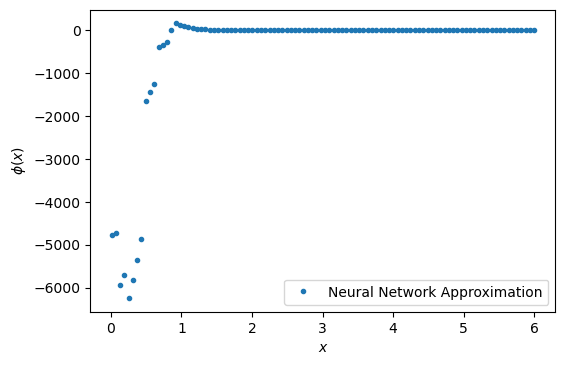

In [35]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]

with torch.no_grad():
    yy = Phi_t(torch.Tensor(rr).to(device)).cpu().numpy()
#yt = xx**2 + np.exp(-xx**2 / 2)/(1+xx+xx**3)

fig, axs = plt.subplots(dpi=100)
#axs.plot(xx, yt, label="True")
axs.plot(rr, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$\phi(x)$")
plt.legend(loc="best")